In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats


#for LDA:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

color_dict = dict(zip(focus_countries, colors))

In [2]:
DATA_PATH = 'data'
df_date_clean = pd.read_csv(DATA_PATH + '/df_date_clean.csv')
df_date_clean['Movie genres'] = df_date_clean['Movie genres'].str.lower().str.strip() # a faire plutot dans la fcto qui fait df_date_clean
df_date_clean.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],United States of America,thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,['English Language'],United States of America,mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,['Norwegian Language'],Norway,crime fiction
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],United Kingdom,thriller
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],Germany,drama


In [3]:
# function that extracts the meaningful words in each XML file
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            if pos in {'NN', 'NNS'} or pos.startswith('VB') or pos.startswith('JJ'):
                filtered_words.append(lemma)
        return ' '.join(filtered_words)

In [4]:
#os.chdir(os.path.join(os.getcwd(), "..", ".."))

tar_path = 'data/corenlp_plot_summaries.tar'

documents = []
ids = []


with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                film_id = int(film_id)
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

## General LDA analysis

In [5]:
#general dictionnary and corpus
tokenized_documents_general = [[word for word in doc.lower().split() if len(word) >= 2] for doc in documents]
dictionary_general = Dictionary(tokenized_documents_general)
max_freq = 0.3
min_wordcount = 5
dictionary_general.filter_extremes(no_below=min_wordcount, no_above=max_freq)
corpus_general = [dictionary_general.doc2bow(doc) for doc in tokenized_documents_general]

In [6]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            workers=4,
            random_state=42,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values 

In [7]:
start = 2
limit = 6
step = 1
models_general, coherences_general = compute_coherence_values(dictionary=dictionary_general, corpus=corpus_general, texts=tokenized_documents_general, start=start, limit=limit, step=step)

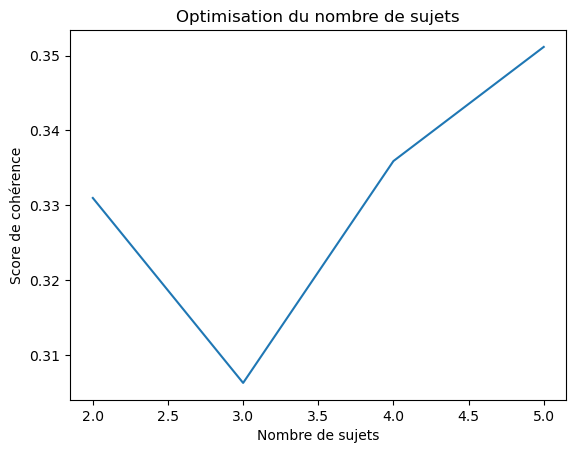

In [8]:
x = range(start, limit, step)
plt.plot(x, coherences_general)
plt.xlabel("Nombre de sujets")
plt.ylabel("Score de cohérence")
plt.title("Optimisation du nombre de sujets")
plt.show()

In [9]:
# By doing a compromise between coherence and interpretability, we choose for the three genres to identify only 4 topics (3rd model in our dictionnaries):
num_topics_selected = 4

selected_models_general= models_general[num_topics_selected - 2]
selected_coherences = coherences_general[num_topics_selected - 2]

print(f"Coherence of the selected model: {selected_coherences}\n")
for idx, topic in selected_models_general.print_topics(-1):
    print(f"Topic {idx}: {topic}")
print("\n\n")

Coherence of the selected model: 0.33591797528285205

Topic 0: 0.010*"love" + 0.008*"friend" + 0.008*"tell" + 0.008*"father" + 0.007*"mother" + 0.007*"family" + 0.006*"meet" + 0.006*"come" + 0.006*"day" + 0.006*"home"
Topic 1: 0.007*"use" + 0.005*"ship" + 0.005*"other" + 0.005*"attack" + 0.004*"destroy" + 0.004*"escape" + 0.004*"kill" + 0.004*"time" + 0.004*"begin" + 0.004*"group"
Topic 2: 0.011*"kill" + 0.005*"father" + 0.005*"son" + 0.005*"fight" + 0.005*"return" + 0.005*"family" + 0.004*"village" + 0.004*"brother" + 0.004*"death" + 0.004*"help"
Topic 3: 0.012*"kill" + 0.010*"tell" + 0.008*"see" + 0.008*"police" + 0.007*"house" + 0.007*"car" + 0.006*"run" + 0.005*"shoot" + 0.005*"call" + 0.005*"arrive"





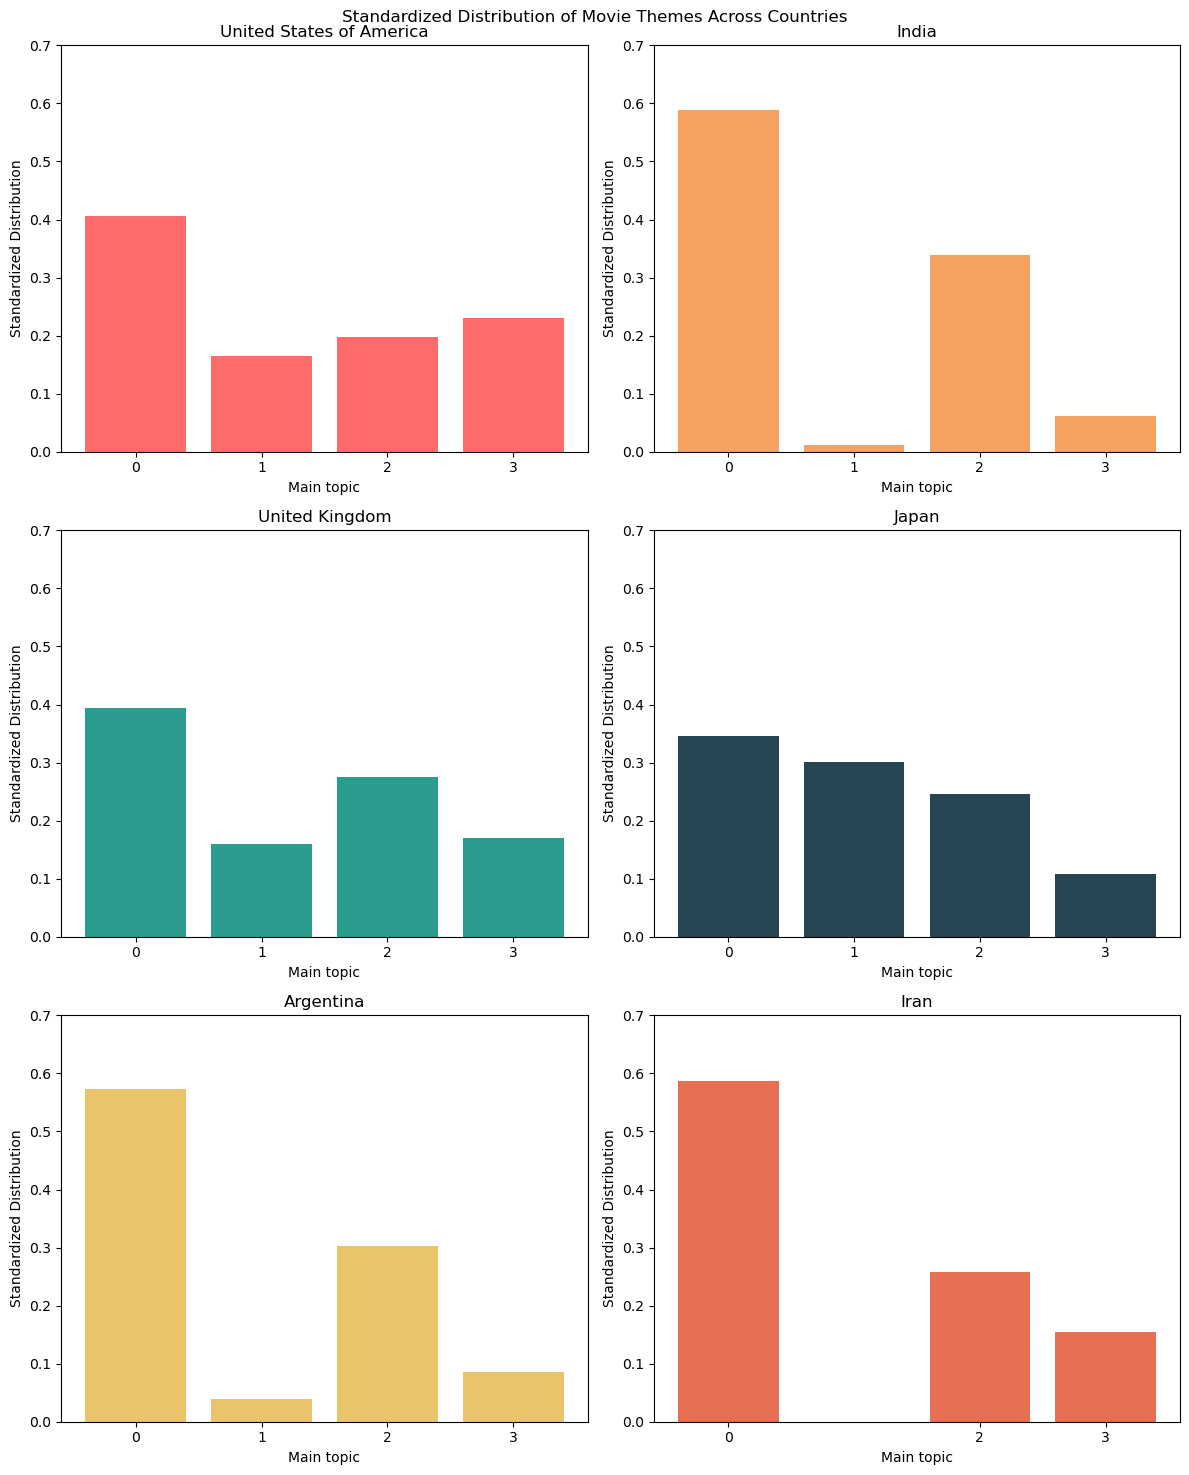

In [10]:
top_themes_per_document = []
for i, doc in enumerate(corpus_general):
    doc_topics = selected_models_general.get_document_topics(doc, minimum_probability=0)
    sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    top_indices = [topic_id for topic_id, _ in sorted_doc_topics[:3]]
    top_proportions = [proportion for _, proportion in sorted_doc_topics[:3]]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Theme 1": top_indices[0],
        "Prop Theme 1": top_proportions[0],
        "Theme 2": top_indices[1],
        "Prop Theme 2": top_proportions[1],
        "Theme 3": top_indices[2],
        "Prop Theme 3": top_proportions[2]
    })

df_top_themes = pd.DataFrame(top_themes_per_document)

df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries')
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    movies = merged_df[merged_df['Movie country'] == country]
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()

    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"{country}")
    axes[idx].set_xlabel("Main topic")
    axes[idx].set_ylabel("Standardized Distribution")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index)

for ax in axes:
    ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

## Specific on genre analysis

In [109]:
movie_genres=df_date_clean["Movie genres"].unique()
genre_documents = {genre: [] for genre in movie_genres}
ids_documents = {genre: [] for genre in movie_genres}
number_films_minimum = 1000 #treshold for the number of films

for i, doc in enumerate(documents):
    row = df_date_clean[df_date_clean['Wikipedia movie ID'].astype(int) == ids[i]]
    if not row.empty:
        genre = row['Movie genres'].iloc[0]
        genre_documents[genre].append(doc)
        ids_documents[genre].append(ids[i])
    else:
        # Skip if no matching row found
        continue

In [110]:
filter_genre_documents = {key: value for key, value in genre_documents.items() if len(value) > number_films_minimum}

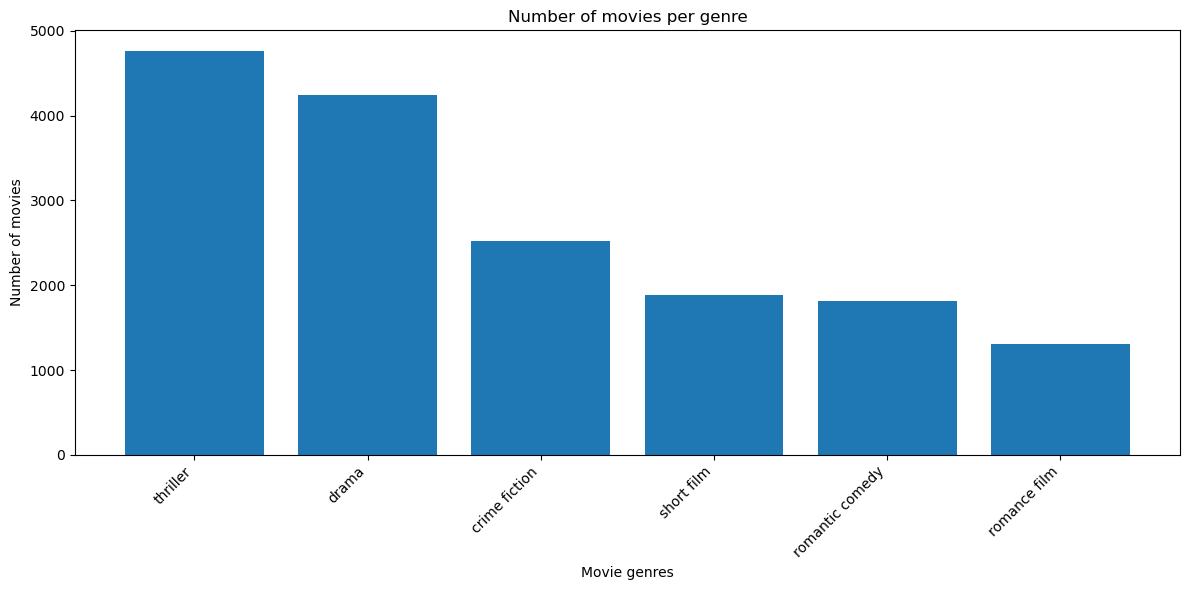

In [111]:
genre_counts = {genre: len(docs) for genre, docs in filter_genre_documents.items()}
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

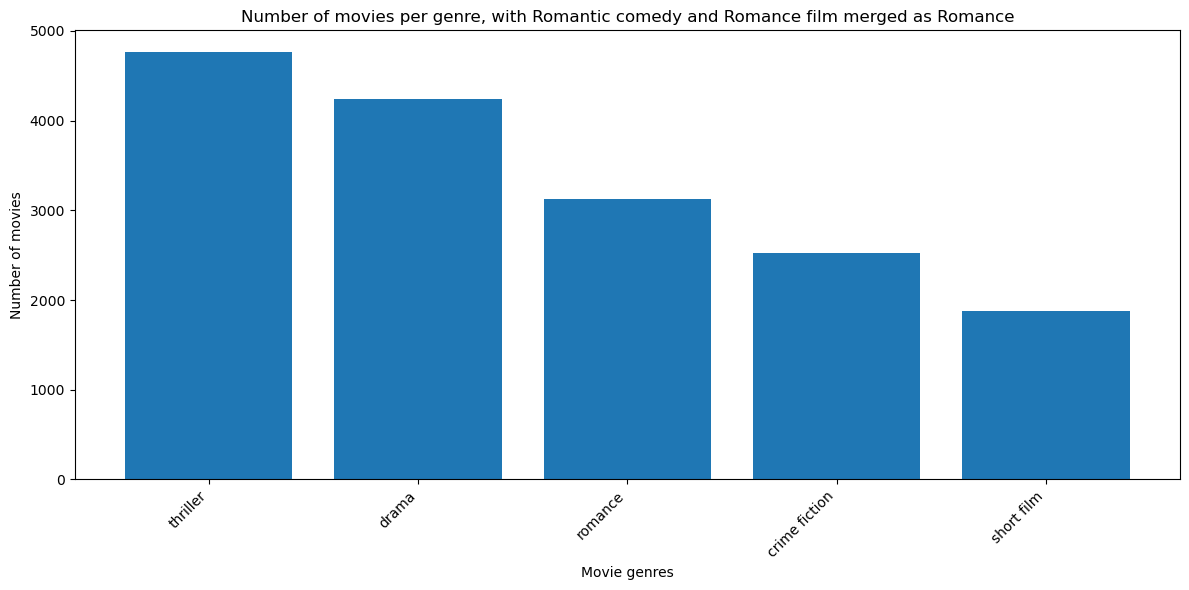

In [112]:
merged_genres = {}
merged_genres['romance'] = []

for genre, docs in filter_genre_documents.items():
    if genre in ['romantic comedy', 'romance film']:
        merged_genres['romance'].extend(docs)
    else:
        if genre not in merged_genres:
            merged_genres[genre] = []
        merged_genres[genre].extend(docs)

genre_counts2 = {genre: len(docs) for genre, docs in merged_genres.items()}
genre_counts2 = dict(sorted(genre_counts2.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts2.keys(), genre_counts2.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre, with Romantic comedy and Romance film merged as Romance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

So we can study the topics in those top 3 genres: Thriller, Drama and Romance

In [113]:
top_3_genres = list(genre_counts2.keys())[:3]
top_3_genres_dict = {genre: merged_genres[genre] for genre in top_3_genres}
print(top_3_genres_dict.keys())

dict_keys(['thriller', 'drama', 'romance'])


In [114]:
# Specific dictionnary and corpus per genres
genre_tokenized_documents = {genre: [] for genre in top_3_genres_dict}
genre_dictionary = {genre: [] for genre in top_3_genres_dict}
genre_corpus = {genre: [] for genre in top_3_genres_dict}
genre_models = {genre: [] for genre in top_3_genres_dict}

for genre in top_3_genres_dict:
    tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in top_3_genres_dict[genre]]
    dictionary = Dictionary(tokenized_documents)
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    genre_tokenized_documents[genre] = tokenized_documents
    genre_dictionary[genre] = dictionary
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
    genre_corpus[genre] = corpus

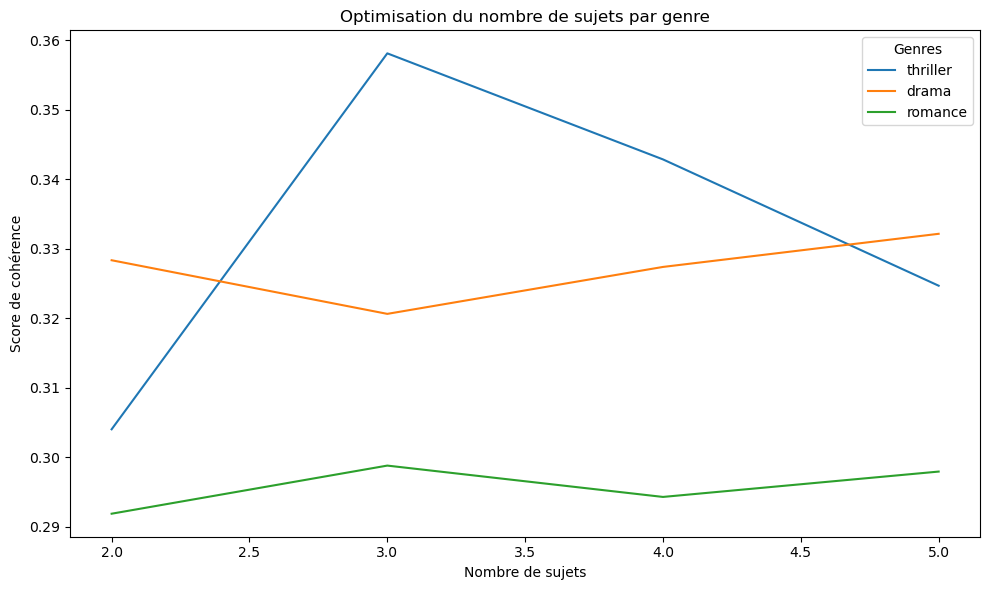

In [115]:
coherence_values = {genre: [] for genre in top_3_genres_dict}
plt.figure(figsize=(10, 6))
for genre in top_3_genres_dict:
    genre_models[genre], coherence_values[genre] = compute_coherence_values(dictionary=genre_dictionary[genre], corpus=genre_corpus[genre], texts=genre_tokenized_documents[genre], start=start, limit=limit, step=step)
    
for genre, values in coherence_values.items():
    plt.plot(x, values, label=genre)
    
plt.xlabel("Nombre de sujets")
plt.ylabel("Score de cohérence")
plt.title("Optimisation du nombre de sujets par genre")
plt.legend(title="Genres")  # Ajouter une légende pour distinguer les genres
plt.tight_layout()
plt.show()

In [116]:
# By doing a compromise between coherence and interpretability, we choose for the three genres to identify only 4 topics (3rd model in our dictionnaries):
num_topics_selected = 4
selected_models = {}
selected_coherences = {}

for genre, models in genre_models.items():
    selected_models[genre] = models[num_topics_selected - 2]
    selected_coherences[genre] = coherence_values[genre][num_topics_selected - 2]

for genre in selected_models:
    print(f"Genre: {genre}")
    print(f"Coherence of the selected model: {selected_coherences[genre]}\n")
    for idx, topic in selected_models[genre].print_topics(-1):
        print(f"Topic {idx}: {topic}")
    print("\n\n")

Genre: thriller
Coherence of the selected model: 0.34283746971907925

Topic 0: 0.007*"attack" + 0.005*"order" + 0.005*"group" + 0.005*"team" + 0.004*"force" + 0.004*"attempt" + 0.004*"agent" + 0.004*"ship" + 0.004*"shoot" + 0.004*"arrive"
Topic 1: 0.006*"father" + 0.005*"woman" + 0.005*"love" + 0.005*"wife" + 0.005*"mother" + 0.005*"family" + 0.004*"child" + 0.004*"young" + 0.004*"home" + 0.004*"year"
Topic 2: 0.009*"car" + 0.009*"house" + 0.006*"shoot" + 0.006*"run" + 0.005*"arrive" + 0.005*"money" + 0.005*"room" + 0.005*"home" + 0.005*"ask" + 0.005*"gun"
Topic 3: 0.004*"room" + 0.004*"work" + 0.004*"attempt" + 0.003*"know" + 0.003*"alien" + 0.003*"name" + 0.003*"human" + 0.003*"lead" + 0.003*"realize" + 0.003*"body"



Genre: drama
Coherence of the selected model: 0.32736150039139583

Topic 0: 0.013*"tell" + 0.008*"see" + 0.007*"mother" + 0.007*"day" + 0.006*"home" + 0.006*"father" + 0.006*"ask" + 0.006*"friend" + 0.006*"come" + 0.006*"return"
Topic 1: 0.013*"family" + 0.011*"love" +

In [140]:
# le problème ici c est que j ai modifié les genres sans changer les ids en conséquence!!! ==> a refaire proprement ==> retourner a la cell ou on met ensemble le romantisme pour mettre ensemble les ids aussi!

top_themes_per_document_by_genre = {}

for genre in selected_models:
    if genre == 'romance':
        # Assuming ids_documents is a dictionary or DataFrame
        ids_documents_genre = pd.concat([ids_documents['romantic comedy'], ids_documents['romance film']])
    else:
        ids_documents_genre = ids_documents[genre].astype(int)

                                  
    top_themes = []
    model = selected_models[genre]
    corpus = genre_corpus[genre]
    
    # Calculer les top thèmes par document
    for i, doc in enumerate(corpus):
        doc_topics = model.get_document_topics(doc, minimum_probability=0)
        top_topic = max(doc_topics, key=lambda x: x[1])  # Trouver le thème avec la probabilité max
        top_themes.append(top_topic[0])  # Ajouter l'ID du top thème

    # Construire un DataFrame avec les IDs des films et leurs top thèmes
    genre_df = pd.DataFrame({
        "Wikipedia movie ID": ids_documents[genre],
        "Theme 1": top_themes
    })
    genre_df.head()
    
    # Fusionner avec df_date_clean pour obtenir des informations supplémentaires
    df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(int)
    genre_df['Wikipedia movie ID'] = genre_df['Wikipedia movie ID'].astype(int)

    
    genre_df = pd.merge(df_date_clean, genre_df, on="Wikipedia movie ID", how="inner")
    top_themes_per_document_by_genre[genre] = genre_df

# Tracer les graphiques
fig, axes = plt.subplots(len(selected_models), 1, figsize=(10, 5 * len(selected_models)))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries by Genre')

# Si un seul graphique est demandé, axes doit être une liste
if len(selected_models) == 1:
    axes = [axes]

for idx, genre in enumerate(selected_models):
    merged_df = top_themes_per_document_by_genre[genre]
    
    # Calculer les proportions des thèmes principaux par pays
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0)
    
    # Tracer pour les pays ciblés
    ax = axes[idx]
    theme_proportions.loc[focus_countries].plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f"{genre}")
    ax.set_xlabel("Countries")
    ax.set_ylabel("Proportion")
    ax.legend(title="Themes", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


TypeError: list indices must be integers or slices, not str